# 优化与深度学习

## 优化与估计

尽管优化方法可以最小化深度学习中的损失函数值，但本质上优化方法达到的目标与深度学习的目标并不相同。
- 优化方法目标：训练集损失函数值
- 深度学习目标：测试集损失函数值（泛化性）

In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import d2lzh1981 as d2l
from mpl_toolkits import mplot3d # 三维画图
import numpy as np

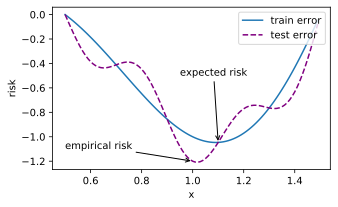

In [2]:
def f(x): return x * np.cos(np.pi * x)
def g(x): return f(x) + 0.2 * np.cos(5 * np.pi * x)

d2l.set_figsize((5, 3))
x = np.arange(0.5, 1.5, 0.01)
fig_f, = d2l.plt.plot(x, f(x),label="train error")
fig_g, = d2l.plt.plot(x, g(x),'--', c='purple', label="test error")
fig_f.axes.annotate('empirical risk', (1.0, -1.2), (0.5, -1.1),arrowprops=dict(arrowstyle='->'))
fig_g.axes.annotate('expected risk', (1.1, -1.05), (0.95, -0.5),arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('risk')
d2l.plt.legend(loc="upper right")

## 优化在深度学习中的挑战
1. 局部最小值
2. 鞍点
3. 梯度消失

### 局部最小值
深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化


$$
f(x) = x\cos \pi x
$$


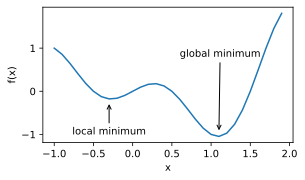

In [3]:
def f(x):
    return x * np.cos(np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

### 鞍点
刚刚我们提到，梯度接近或变成零可能是由于当前解在局部最优解附近造成的。事实上，另一种可能性是当前解在鞍点（saddle point）附近
假设一个函数的输入为 𝑘k 维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有 𝑘k 个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。

当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。

当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5 。那么，以上第一种情况的概率为$0.5^{k}$。由于深度学习模型参数通常都是高维的（ 𝑘 很大），目标函数的鞍点通常比局部最小值更常见。


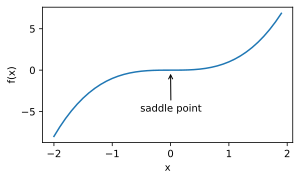

In [4]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');


$$
A=\left[\begin{array}{cccc}{\frac{\partial^{2} f}{\partial x_{1}^{2}}} & {\frac{\partial^{2} f}{\partial x_{1} \partial x_{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{1} \partial x_{n}}} \\ {\frac{\partial^{2} f}{\partial x_{2} \partial x_{1}}} & {\frac{\partial^{2} f}{\partial x_{2}^{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{2} \partial x_{n}}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\frac{\partial^{2} f}{\partial x_{n} \partial x_{1}}} & {\frac{\partial^{2} f}{\partial x_{n} \partial x_{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{n}^{2}}}\end{array}\right]
$$


e.g.

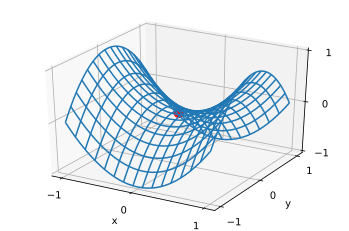

In [5]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'ro', markersize=10)
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

### 梯度消失

Text(2, 0.0, 'vanishing gradient')

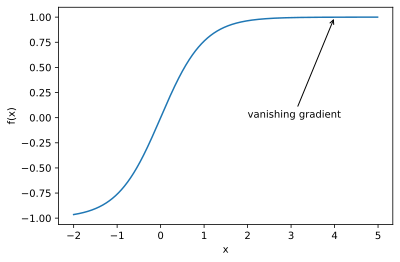

In [6]:
x = np.arange(-2.0, 5.0, 0.01)
fig, = d2l.plt.plot(x, np.tanh(x))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')
fig.axes.annotate('vanishing gradient', (4, 1), (2, 0.0) ,arrowprops=dict(arrowstyle='->'))

# 凸性 （Convexity）

## 基础

### 集合
凸集合的交集必定是凸集合，凸集合的并集不一定是凸集合

![Image Name](https://cdn.kesci.com/upload/image/q5p1yhqzm8.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1xz9gvz.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1yue9fu.png?imageView2/0/w/320/h/320)



### 函数
下式表示函数值的期望大于期望的函数值


$$
\lambda f(x)+(1-\lambda) f\left(x^{\prime}\right) \geq f\left(\lambda x+(1-\lambda) x^{\prime}\right)
$$


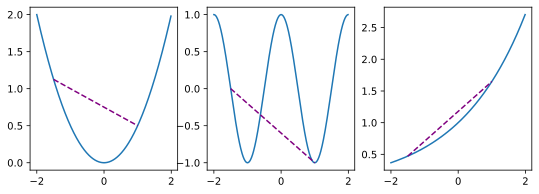

In [7]:
def f(x):
    return 0.5 * x**2  # Convex

def g(x):
    return np.cos(np.pi * x)  # Nonconvex

def h(x):
    return np.exp(0.5 * x)  # Convex

x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))

for ax, func in zip(axes, [f, g, h]):
    ax.plot(x, func(x))
    ax.plot(segment, func(segment),'--', color="purple")
    # d2l.plt.plot([x, segment], [func(x), func(segment)], axes=ax)

### Jensen 不等式


$$
\sum_{i} \alpha_{i} f\left(x_{i}\right) \geq f\left(\sum_{i} \alpha_{i} x_{i}\right) \text { and } E_{x}[f(x)] \geq f\left(E_{x}[x]\right)
$$


---

## 性质
1. 无局部极小值
2. 与凸集的关系
3. 二阶条件

###  无局部最小值

证明：假设存在 $x \in X$ 是局部最小值，则存在全局最小值 $x' \in X$, 使得 $f(x) > f(x')$, 则对 $\lambda \in(0,1]$:

$$
f(x)>\lambda f(x)+(1-\lambda) f(x^{\prime}) \geq f(\lambda x+(1-\lambda) x^{\prime})
$$


### 与凸集的关系

对于凸函数 $f(x)$，定义集合 $S_{b}:=\{x | x \in X \text { and } f(x) \leq b\}$，则集合 $S_b$ 为凸集

证明：对于点 $x,x' \in S_b$, 有 $f\left(\lambda x+(1-\lambda) x^{\prime}\right) \leq \lambda f(x)+(1-\lambda) f\left(x^{\prime}\right) \leq b$, 故 $\lambda x+(1-\lambda) x^{\prime} \in S_{b}$

$f(x, y)=0.5 x^{2}+\cos (2 \pi y)$

In [12]:
x, y = np.meshgrid(np.linspace(-1, 1, 101), np.linspace(-1, 1, 101),
                   indexing='ij')

z = x**2 + 0.5 * np.cos(2 * np.pi * y)

# Plot the 3D surface
d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.contour(x, y, z, offset=-1)
ax.set_zlim(-1, 1.5)

# Adjust labels
for func in [d2l.plt.xticks, d2l.plt.yticks, ax.set_zticks]:
    func([-1, 0, 1])

<Figure size 432x288 with 1 Axes>

### 凸函数与二阶导数

$f^{''}(x) \ge 0 \Longleftrightarrow f(x)$ 是凸函数

**必要性 ($\Leftarrow$):**

对于凸函数：

$$
\frac{1}{2} f(x+\epsilon)+\frac{1}{2} f(x-\epsilon) \geq f\left(\frac{x+\epsilon}{2}+\frac{x-\epsilon}{2}\right)=f(x)
$$

故:

$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{\frac{f(x+\epsilon) - f(x)}{\epsilon}-\frac{f(x) - f(x-\epsilon)}{\epsilon}}{\epsilon}
$$


$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{f(x+\epsilon)+f(x-\epsilon)-2 f(x)}{\epsilon^{2}} \geq 0
$$


**充分性 ($\Rightarrow$):**

令 $a < x < b$ 为 $f(x)$ 上的三个点，由拉格朗日中值定理:

$$
\begin{array}{l}{f(x)-f(a)=(x-a) f^{\prime}(\alpha) \text { for some } \alpha \in[a, x] \text { and }} \\ {f(b)-f(x)=(b-x) f^{\prime}(\beta) \text { for some } \beta \in[x, b]}\end{array}
$$


根据单调性，有 $f^{\prime}(\beta) \geq f^{\prime}(\alpha)$, 故:

$$
\begin{aligned} f(b)-f(a) &=f(b)-f(x)+f(x)-f(a) \\ &=(b-x) f^{\prime}(\beta)+(x-a) f^{\prime}(\alpha) \\ & \geq(b-a) f^{\prime}(\alpha) \end{aligned}
$$

In [13]:
def f(x):
    return 0.5 * x**2

x = np.arange(-2, 2, 0.01)
axb, ab = np.array([-1.5, -0.5, 1]), np.array([-1.5, 1])

d2l.set_figsize((3.5, 2.5))
fig_x, = d2l.plt.plot(x, f(x))
fig_axb, = d2l.plt.plot(axb, f(axb), '-.',color="purple")
fig_ab, = d2l.plt.plot(ab, f(ab),'g-.')

fig_x.axes.annotate('a', (-1.5, f(-1.5)), (-1.5, 1.5),arrowprops=dict(arrowstyle='->'))
fig_x.axes.annotate('b', (1, f(1)), (1, 1.5),arrowprops=dict(arrowstyle='->'))
fig_x.axes.annotate('x', (-0.5, f(-0.5)), (-1.5, f(-0.5)),arrowprops=dict(arrowstyle='->'))

Text(-1.5, 0.125, 'x')

<Figure size 252x180 with 1 Axes>

## 限制条件


$$
\begin{array}{l}{\underset{\mathbf{x}}{\operatorname{minimize}} f(\mathbf{x})} \\ {\text { subject to } c_{i}(\mathbf{x}) \leq 0 \text { for all } i \in\{1, \ldots, N\}}\end{array}
$$


### 拉格朗日乘子法
[Boyd & Vandenberghe, 2004](https://d2l.ai/chapter_references/zreferences.html#boyd-vandenberghe-2004)


$$
L(\mathbf{x}, \alpha)=f(\mathbf{x})+\sum_{i} \alpha_{i} c_{i}(\mathbf{x}) \text { where } \alpha_{i} \geq 0
$$


### 惩罚项

欲使 $c_i(x) \leq 0$, 将项 $\alpha_ic_i(x)$ 加入目标函数，如多层感知机章节中的 $\frac{\lambda}{2} ||w||^2$

### 投影


$$
\operatorname{Proj}_{X}(\mathbf{x})=\underset{\mathbf{x}^{\prime} \in X}{\operatorname{argmin}}\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|_{2}
$$



![Image Name](https://cdn.kesci.com/upload/image/q5p241skoc.png?imageView2/0/w/640/h/640)
